<a href="https://colab.research.google.com/github/raycmarange/AIML431New/blob/main/assign4_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Found file at: /content/SMSSpamCollection.txt
Successfully loaded with tab delimiter
Dataset loaded: 5572 samples
Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
Label mapping result:
label
0    4825
1     747
Name: count, dtype: int64
Final dataset size: 5572
Class distribution: {0: 4825, 1: 747}
Training samples: 4457, Testing samples: 1115


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Training batches: 279, Testing batches: 70


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Starting training...
Epoch 1/3, Average Loss: 0.0910
Epoch 2/3, Average Loss: 0.0122
Epoch 3/3, Average Loss: 0.0088
Evaluating model...

EVALUATION RESULTS
Test Accuracy: 0.9892
Weighted F1 Score: 0.9892
Confusion Matrix:
[[961   5]
 [  7 142]]

Classification Report:
               precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.97      0.95      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115

Creating TSNE Visualization of [CLS] Token Embeddings...


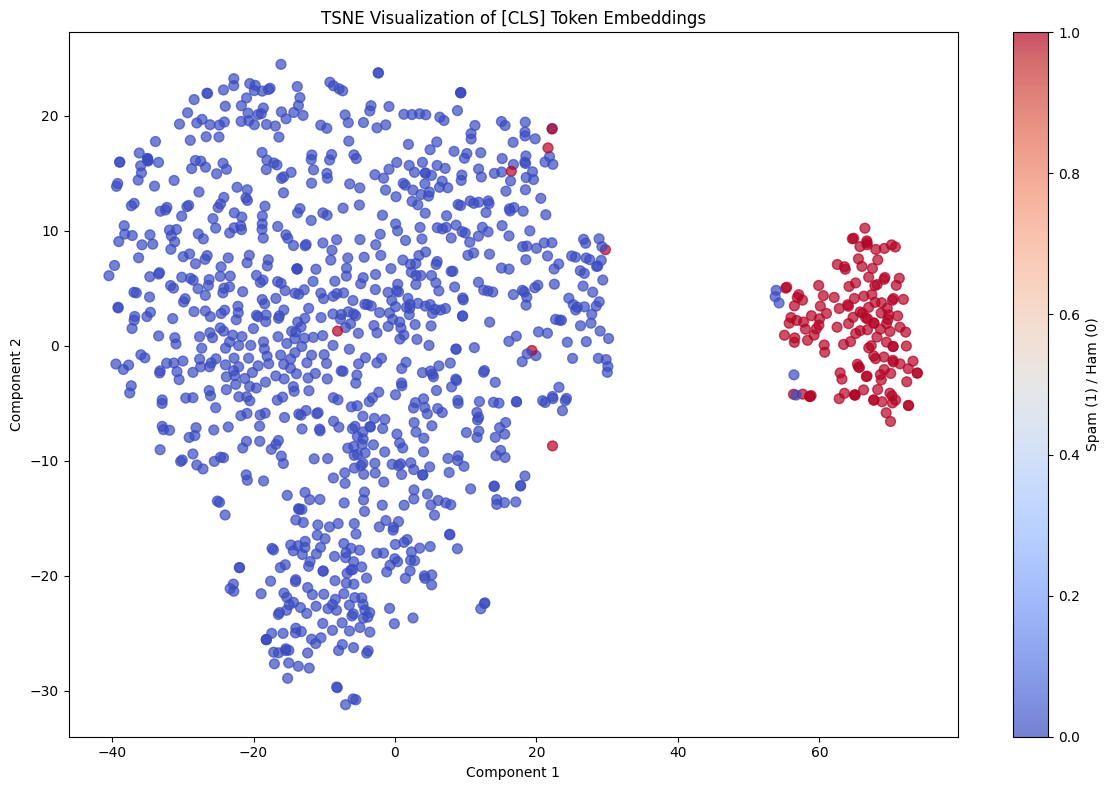

Creating PCA Visualization of [CLS] Token Embeddings...


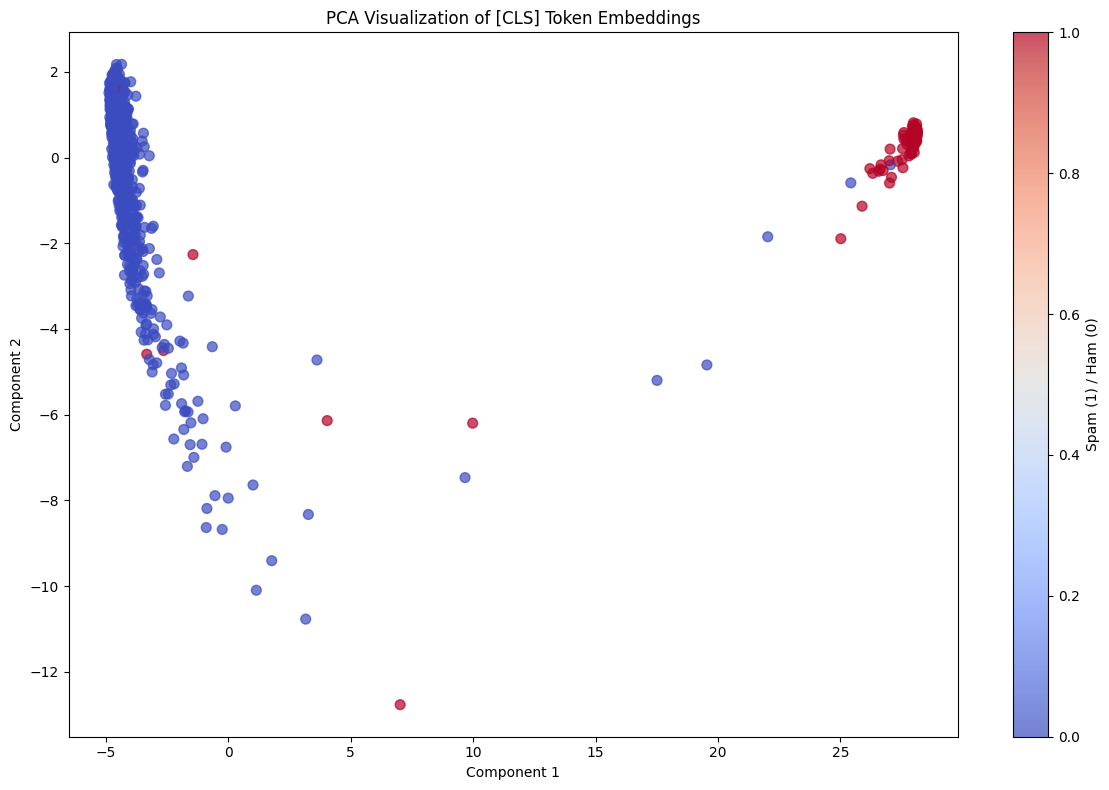

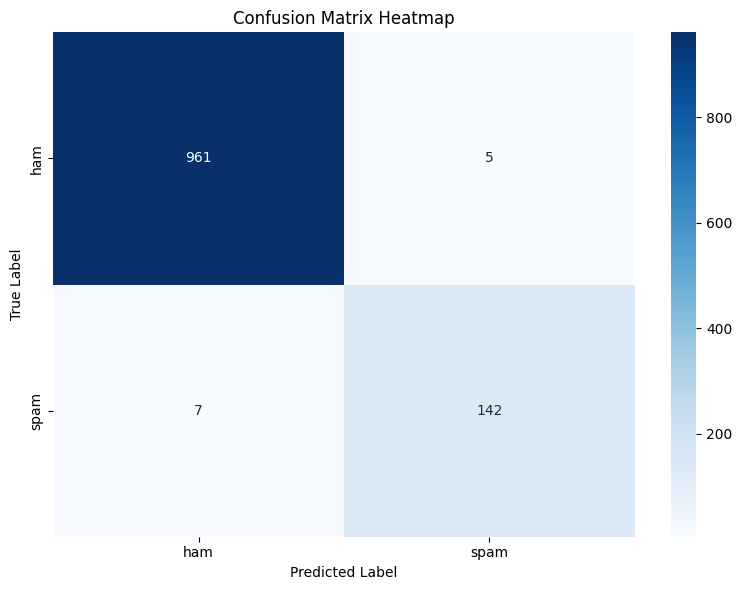

Script execution completed!


In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tqdm.auto')
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=SyntaxWarning)

import torch
import pandas as pd
import numpy as np
import os
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm.auto import tqdm

def run_task1_baseline(file_path):
    """
    Runs the full Task 1 pipeline: data loading, preprocessing,
    BERT model fine-tuning, evaluation, and visualization.
    """
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Preprocessing and Tokenization (15%)
    def load_and_preprocess_data(file_path):
        """Load and preprocess the SMS Spam Collection dataset"""
        try:
            df = pd.read_csv(file_path, delimiter='\t', header=None, names=['label', 'text'], encoding='utf-8')
            print("Successfully loaded with tab delimiter")
        except Exception as e:
            print(f"Error with tab delimiter: {e}")
            try:
                df = pd.read_csv(file_path, delimiter=',', header=None, names=['label', 'text'], encoding='utf-8')
                print("Successfully loaded with comma delimiter")
            except Exception as e2:
                print(f"Error with comma delimiter: {e2}")
                print("Attempting manual file reading...")
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        lines = f.readlines()
                    data = []
                    for line in lines:
                        parts = line.strip().split('\t', 1)
                        if len(parts) == 2:
                            data.append(parts)
                        else:
                            parts = line.strip().split(' ', 1)
                            if len(parts) == 2:
                                data.append(parts)
                    df = pd.DataFrame(data, columns=['label', 'text'])
                    print("Successfully loaded with manual parsing")
                except Exception as e3:
                    print(f"All loading methods failed: {e3}")
                    return None

        if df is None or len(df) == 0:
            print("Failed to load any data")
            return None

        print(f"Dataset loaded: {len(df)} samples")
        print(f"Label distribution:\n{df['label'].value_counts()}")

        df['label'] = df['label'].map({'ham': 0, 'spam': 1})
        print(f"Label mapping result:\n{df['label'].value_counts()}")
        df = df.dropna()
        return df

    def tokenize_data(texts, labels, tokenizer, max_length=128):
        if hasattr(texts, 'tolist'):
            texts = texts.tolist()
        elif hasattr(texts, 'values'):
            texts = texts.values.tolist()

        encoded_data = tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        input_ids = encoded_data['input_ids']
        attention_masks = encoded_data['attention_mask']
        labels_tensor = torch.tensor(labels)
        return input_ids, attention_masks, labels_tensor

    # --- File path detection and data loading ---
    current_dir = os.getcwd()
    possible_paths = [
        "SMSSpamCollection",
        f"{current_dir}/SMSSpamCollection",
        f"{current_dir}/SMSSpamCollection.txt",
    ]
    file_path = None
    for path in possible_paths:
        if os.path.exists(path):
            file_path = path
            print(f"Found file at: {path}")
            break

    if not file_path:
        print("SMSSpamCollection file not found. Creating a sample dataset.")
        sample_data = {'label': ['ham']*10 + ['spam']*10, 'text': [""]*20}
        df = pd.DataFrame(sample_data)
        df['text'] = ["Hey, let's meet up.", "Can you pick up groceries?", "Great job!", "See you tomorrow.", "Don't forget the keys.",
                      "Lunch at 1pm?", "Call me later.", "Are you coming?", "What's up?", "I'm on my way."] + \
                     ["WINNER! Click here to claim your prize.", "URGENT! You've won a new phone.", "Free money now!", "Act fast, limited time offer.", "Get your loan approved today."]
        df['label'] = df['label'].map({'ham': 0, 'spam': 1})
    else:
        df = load_and_preprocess_data(file_path)

    if df is None or len(df) == 0:
        print("Data loading failed, skipping further processing.")
        return

    print(f"Final dataset size: {len(df)}")
    print(f"Class distribution: {df['label'].value_counts().to_dict()}")

    # Split data
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        df['text'].values, df['label'].values, test_size=0.2, random_state=42, stratify=df['label']
    )
    print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")

    # Tokenize data
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_input_ids, train_attention_masks, train_labels_tensor = tokenize_data(train_texts, train_labels, tokenizer)
    test_input_ids, test_attention_masks, test_labels_tensor = tokenize_data(test_texts, test_labels, tokenizer)

    batch_size = 16
    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels_tensor)
    test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

    print(f"Training batches: {len(train_dataloader)}, Testing batches: {len(test_dataloader)}")

    # 2. Model Construction (15%)
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, output_hidden_states=True)
    model.to(device)
    print("Model loaded successfully!")

    # 3. Training the Classifier (15%)
    epochs = 3
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    def train_model(model, train_dataloader, optimizer, scheduler, device):
        model.train()
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        return total_loss / len(train_dataloader)

    print("Starting training...")
    for epoch in range(epochs):
        avg_loss = train_model(model, train_dataloader, optimizer, scheduler, device)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

    # 4. Evaluation (15%)
    def evaluate_model(model, test_dataloader, device):
        model.eval()
        predictions, true_labels, cls_embeddings = [], [], []
        for batch in test_dataloader:
            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            if outputs.hidden_states is not None:
                cls_embedding = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
                cls_embeddings.extend(cls_embedding)
            preds = torch.argmax(logits, dim=1).flatten().cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(b_labels.cpu().numpy())
        return predictions, true_labels, np.array(cls_embeddings) if cls_embeddings else None

    print("Evaluating model...")
    predictions, true_labels, cls_embeddings = evaluate_model(model, test_dataloader, device)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted') if len(np.unique(true_labels)) > 1 else 1.0 if accuracy == 1.0 else 0.0
    conf_matrix = confusion_matrix(true_labels, predictions, labels=sorted(set(true_labels + predictions)))
    target_names = ['ham', 'spam']
    present_target_names = [target_names[i] for i in np.unique(true_labels + predictions) if i < len(target_names)]

    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print("\nClassification Report:\n", classification_report(true_labels, predictions, labels=np.unique(true_labels + predictions), target_names=present_target_names, zero_division=0))

    # 5. Visualization for the testing results (15%)
    def visualize_embeddings(embeddings, labels, method='tsne'):
        if embeddings is None or len(embeddings) < 2:
            print(f"Not enough samples for {method.upper()} visualization.")
            return
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1)) if method == 'tsne' else PCA(n_components=2, random_state=42)
        title = f"{method.upper()} Visualization of [CLS] Token Embeddings"
        print(f"Creating {title}...")
        embeddings_2d = reducer.fit_transform(embeddings)
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7, s=50)
        plt.colorbar(scatter, label='Spam (1) / Ham (0)')
        plt.title(title)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.tight_layout()
        plt.show()

    if cls_embeddings is not None:
        visualize_embeddings(cls_embeddings, true_labels, method='tsne')
        visualize_embeddings(cls_embeddings, true_labels, method='pca')

    if conf_matrix.size > 1:
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=present_target_names, yticklabels=present_target_names)
        plt.title('Confusion Matrix Heatmap')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

    torch.save(model.state_dict(), 'bert_spam_classifier.pth')
    print("Script execution completed!")

# Check if the file exists and run the main function.
try:
    current_dir = os.getcwd()
    file_name = "SMSSpamCollection.txt"
    file_path = os.path.join(current_dir, file_name)
    run_task1_baseline(file_path)
except Exception as e:
    print(f"An error occurred: {e}")